#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [2]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [4]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [5]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [6]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비

In [7]:
# 1) 추적 설정
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* exp4

In [9]:
exp_id = mlflow.create_experiment("exp4")
exp_id

'3'

## 2 데이터 살펴보기

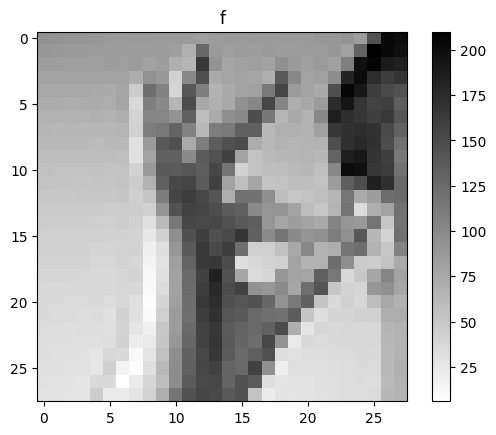

In [12]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 55
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [13]:
target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 데이터 분할2 : train, validation, test

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, random_state=20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2000, random_state=20)

In [15]:
x_train.shape, x_val.shape, x_test.shape

((5000, 784), (2000, 784), (1000, 784))

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [18]:
x_train, x_val, y_train, y_val = x_train.values, x_val.values, y_train.values, y_val.values

* shape 맞추기 n, 28,28,1
    * reshape
        * x_train.shape : (-1, 28, 28, 1)
        * x_val.shape : (-1, 28, 28, 1)
        * x_test.shape : (-1, 28, 28, 1)

In [20]:
x_train = x_train.reshape(5000, 28, 28, 1)
x_val = x_val.reshape(2000, 28, 28, 1)

In [21]:
x_train.shape, x_val.shape

((5000, 28, 28, 1), (2000, 28, 28, 1))

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [22]:
x_train = x_train / 255.
x_val = x_val / 255.

## 4.모델링

### (1) 모델1

- 추가적인 합성곱(Conv2D) 레이어를 도입하고 드롭아웃(Dropout) 레이어를 사용하여 과적합을 방지
- 더 깊은 네트워크로 확장하면서 드롭아웃 레이어를 추가하여 과적합을 줄일 수 있다. 

In [59]:
with mlflow.start_run(experiment_id=exp_id):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model1 = Sequential([
        Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides=1, activation='relu'),
        MaxPooling2D(pool_size=2, strides=2),
        Flatten(),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dense(26, activation='softmax')
    ])
    model1.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model1.fit(x_train, y_train, epochs=30, validation_split=.2).history
    
    # 모델등록
    mlflow.keras.log_model(model1, "keras-model",  registered_model_name="DL_Drop_out")
    
    # autolog 종료
    mlflow.keras.autolog(disable = True)

model1.summary()


Epoch 1/30
125/125 [==============================] - 7s 43ms/step - loss: 2.8997 - val_loss: 2.3026
Epoch 2/30
125/125 [==============================] - 5s 39ms/step - loss: 1.7893 - val_loss: 1.3682
Epoch 3/30
125/125 [==============================] - 5s 39ms/step - loss: 1.1919 - val_loss: 1.0154
Epoch 4/30
125/125 [==============================] - 5s 39ms/step - loss: 0.8081 - val_loss: 0.6992
Epoch 5/30
125/125 [==============================] - 5s 42ms/step - loss: 0.5863 - val_loss: 0.5582
Epoch 6/30
125/125 [==============================] - 5s 39ms/step - loss: 0.4383 - val_loss: 0.4466
Epoch 7/30
125/125 [==============================] - 5s 42ms/step - loss: 0.3490 - val_loss: 0.3422
Epoch 8/30
125/125 [==============================] - 5s 37ms/step - loss: 0.2717 - val_loss: 0.3051
Epoch 9/30
125/125 [==============================] - 5s 38ms/step - loss: 0.2128 - val_loss: 0.2232
Epoch 10/30
125/125 [==============================] - 5s 40ms/step - loss: 0.1750 - val_lo

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwdz2xgyg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwdz2xgyg\model\data\model\assets
2023/05/18 16:40:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpng5ayd2l\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpng5ayd2l\model\data\model\assets
Registered model 'DL_Drop_out' already exists. Creating a new version of this model...
2023/05/18 16:40:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL_Drop_out, version 3
Created version '3' of model 'DL_Drop_out'.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_7 (Dropout)         (None, 6272)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               802944    
                                                                 
 dense_15 (Dense)            (None, 26)                3354      
                                                      

* 학습곡선

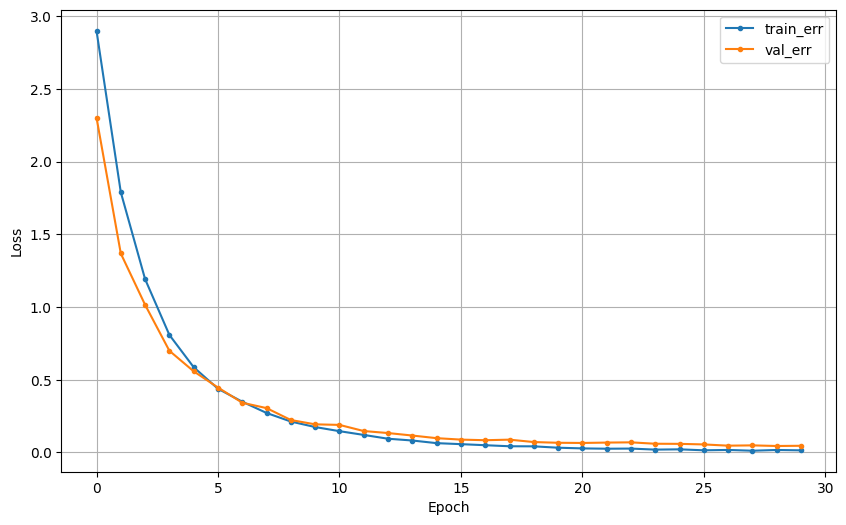

In [60]:
dl_history_plot(history)

* 예측 및 검증

In [61]:
pred = model1.predict(x_val)


63/63 [==============================] - 1s 9ms/step


In [62]:
pred_1 = pred.argmax(axis=1)

In [63]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))

0.9925
------------------------------------------------------------
[[ 77   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  64   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  69   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  96   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  65   0   0   0   0   0   0   2   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0 101   0   0   0   0   0   0   0   0   1   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0  80   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0  79   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  85   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  81

In [64]:
print(classification_report(class_names[y_val], class_names[pred_1]))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        77
           b       1.00      1.00      1.00        64
           c       0.97      1.00      0.99        69
           d       1.00      1.00      1.00        96
           e       1.00      0.94      0.97        69
           f       1.00      0.98      0.99       103
           g       1.00      1.00      1.00        80
           h       1.00      0.98      0.99        81
           i       1.00      1.00      1.00        85
           k       0.99      1.00      0.99        81
           l       1.00      1.00      1.00        86
           m       0.98      1.00      0.99        93
           n       1.00      1.00      1.00        71
           o       1.00      0.98      0.99        87
           p       0.99      1.00      0.99        84
           q       1.00      1.00      1.00        94
           r       0.99      0.97      0.98        89
           s       0.98    

### (2) 모델2

- 컨볼루션 레이어와 풀링 레이어를 여러 번 반복한다. 추가적으로 배치 정규화(BatchNormalization)를 적용하여 학습 안정성을 높일 수 있다.
- 깊은 네트워크 구조에 배치 정규화를 적용하여 학습 안정성을 높일 수 있다.

In [53]:
from tensorflow.keras.layers import BatchNormalization

with mlflow.start_run(experiment_id=exp_id):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model2 = Sequential([
        Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides=1, activation='relu'),
        BatchNormalization(),
        Conv2D(32, kernel_size=3, padding='same', strides=1, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2, strides=2),
        Conv2D(64, kernel_size=3, padding='same', strides=1, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2, strides=2),
        Flatten(),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dense(26, activation='softmax')
    ])
    model2.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model2.fit(x_train, y_train, epochs=30, validation_split=.2).history
    
    # 모델등록
    mlflow.keras.log_model(model2, "keras-model",  registered_model_name="DL_BatchNormalization")
    
    # autolog 종료
    mlflow.keras.autolog(disable = True)

model2.summary()


Epoch 1/30
125/125 [==============================] - 18s 120ms/step - loss: 1.2832 - val_loss: 4.6697
Epoch 2/30
125/125 [==============================] - 14s 111ms/step - loss: 0.1287 - val_loss: 2.9945
Epoch 3/30
125/125 [==============================] - 13s 100ms/step - loss: 0.0376 - val_loss: 1.3704
Epoch 4/30
125/125 [==============================] - 12s 97ms/step - loss: 0.0300 - val_loss: 0.2415
Epoch 5/30
125/125 [==============================] - 12s 99ms/step - loss: 0.0098 - val_loss: 0.0350
Epoch 6/30
125/125 [==============================] - 12s 99ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 7/30
125/125 [==============================] - 12s 98ms/step - loss: 0.0019 - val_loss: 0.0103
Epoch 8/30
125/125 [==============================] - 12s 97ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 9/30
125/125 [==============================] - 12s 96ms/step - loss: 6.0038e-04 - val_loss: 0.0053
Epoch 10/30
125/125 [==============================] - 12s 99ms/step - loss

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpg12thx5d\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpg12thx5d\model\data\model\assets
2023/05/18 15:53:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpfdsaecf4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpfdsaecf4\model\data\model\assets
Registered model 'DL_BatchNormalization' already exists. Creating a new version of this model...
2023/05/18 15:53:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL_BatchNormalization, version 2


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 


Created version '2' of model 'DL_BatchNormalization'.


 batch_normalization_13 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_14 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 3136)              0         
          

* 학습곡선

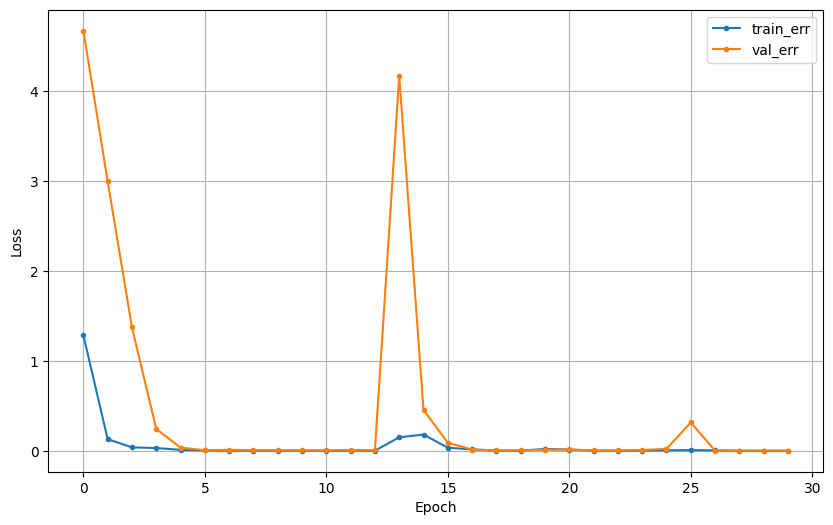

In [54]:
dl_history_plot(history)

* 예측 및 검증

In [55]:
pred = model2.predict(x_val)


63/63 [==============================] - 2s 26ms/step


In [56]:
pred_2 = pred.argmax(axis=1)


In [57]:
print(accuracy_score(y_val,pred_2))
print('-'*60)
print(confusion_matrix(y_val, pred_2))

0.999
------------------------------------------------------------
[[ 77   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  64   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  69   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  96   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  69   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 103   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  80   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  81   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  85   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  81 

In [58]:
print(classification_report(class_names[y_val], class_names[pred_2]))


              precision    recall  f1-score   support

           a       1.00      1.00      1.00        77
           b       1.00      1.00      1.00        64
           c       1.00      1.00      1.00        69
           d       1.00      1.00      1.00        96
           e       1.00      1.00      1.00        69
           f       1.00      1.00      1.00       103
           g       1.00      1.00      1.00        80
           h       1.00      1.00      1.00        81
           i       1.00      1.00      1.00        85
           k       1.00      1.00      1.00        81
           l       1.00      1.00      1.00        86
           m       0.98      1.00      0.99        93
           n       1.00      1.00      1.00        71
           o       1.00      0.98      0.99        87
           p       1.00      1.00      1.00        84
           q       1.00      1.00      1.00        94
           r       1.00      1.00      1.00        89
           s       1.00    

## 5.모델 사용하기
* 가장 성능이 좋은 모델 production 지정
* Production 모델 호출해서 test 셋으로 예측 및 평가

